In [1]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install datasets
!pip install evaluate
!pip install scikit-learn
!pip install transformers
#!pip install peft
!pip install wandb
!pip install emoji
!pip install accelerate
!pip install -U bitsandbytes peft
!pip install focal-loss-torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 8.7 MB/s eta 0:00:00
  

In [3]:


import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, BitsAndBytesConfig, AutoConfig
from peft import LoraConfig, TaskType, get_peft_model
from datasets import Dataset, DatasetDict
from evaluate import load as load_metric
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from torch.utils.data import DataLoader
import emoji
import re  # For regular expressions
from huggingface_hub import login
import gc
import time
from accelerate import infer_auto_device_map, dispatch_model
from pathlib import Path

In [4]:
# Replace 'your_hf_token' with the token you generated
login(token="XXXX")

In [5]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [63]:
# Set file paths
train_path = '/content/drive/MyDrive/data/datasets/train.csv'
test_path = '/content/drive/MyDrive/data/datasets/test.csv'

# Load the data
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [64]:
# Replace 'NONE' with 0 in emotion columns
label_names = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
df_train[label_names] = df_train[label_names].replace('NONE', 0).astype(int)
df_test[label_names] = df_test[label_names].replace('NONE', 0).astype(int)

<ipython-input-64-d4ce96155885>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test[label_names] = df_test[label_names].replace('NONE', 0).astype(int)


In [65]:
# Split data into train and validation sets
train_df, val_df = train_test_split(df_train, test_size=0.2, random_state=42)

# Convert DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(df_test)

In [66]:
def free_gpu_memory():
    """
    Frees up GPU memory after CUDA out-of-memory error in Colab.

    This function performs the following steps:
    1. Deletes all PyTorch objects to clear references.
    2. Calls garbage collection to remove unreferenced objects from memory.
    3. Uses torch.cuda.empty_cache() to release cached GPU memory.
    4. Waits for a moment to ensure memory is fully released.
    """
    try:
        # Delete all torch tensors to free up memory
        for obj in list(locals().values()):
            if torch.is_tensor(obj):
                del obj

        # Collect garbage to release any remaining unused memory
        gc.collect()

        # Empty the CUDA cache to release GPU memory
        torch.cuda.empty_cache()

        # Adding a small delay to allow memory to be fully released
        time.sleep(2)

        print("GPU memory has been freed.")
    except Exception as e:
        print(f"Error while freeing GPU memory: {e}")


In [67]:
free_gpu_memory()

GPU memory has been freed.


In [68]:
checkpoint = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=len(label_names),
    problem_type="multi_label_classification",
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

# Ensure padding token is set correctly for Llama models
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})  # Add '[PAD]' as pad token
tokenizer.pad_token = tokenizer.eos_token if tokenizer.pad_token is None else tokenizer.pad_token

# Add additional special tokens
special_tokens_dict = {'unk_token': '[UNK]', 'eos_token': '[EOS]'}
tokenizer.add_special_tokens(special_tokens_dict)

# Resize model embeddings to match updated tokenizer
model.resize_token_embeddings(len(tokenizer))  # Ensure model embeddings match tokenizer vocab

# Check alignment
tokenizer_vocab_size = len(tokenizer.get_vocab())
model_vocab_size = model.get_input_embeddings().weight.shape[0]
assert tokenizer_vocab_size == model_vocab_size, "Tokenizer and model vocab sizes mismatch!"
print(f"Tokenizer vocab size: {tokenizer_vocab_size}")
print(f"Model embedding size: {model_vocab_size}")


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizer vocab size: 128259
Model embedding size: 128259


In [69]:
all_lengths = [len(tokenizer(Tweet)["input_ids"]) for Tweet in df_train["Tweet"]]
max_length = int(np.percentile(all_lengths, 95))  # Use 95th percentile
print(f"max_length: {max_length}")

max_length: 42


In [70]:
max_length = max_length
print(max_length)

42


In [71]:
# Function to preprocess text
def preprocess_text(text):
  # Expand contractions
  text = re.sub(r"n\'t", " not", text)
  text = re.sub(r"\'re", " are", text)
  # ... other contractions ...

  # Remove unnecessary characters and extra whitespace
  text = re.sub(r"[^\w\s]", "", text)
  text = re.sub(r"\s+", " ", text).strip()

  # Handle URLs and hashtags (you can customize this)
  text = re.sub(r"http\S+", "URL", text)
  text = re.sub(r"#\w+", "HASHTAG", text)

  # Handle emojis
  text = emoji.demojize(text)  # Convert emojis to text descriptions
  text = re.sub(r":[^:]+:", "", text)  # Remove emoji descriptions

  return text

# Tokenization function
def preprocess_function(examples):
    examples["Tweet"] = [preprocess_text(text) for text in examples["Tweet"]]
    return tokenizer(examples["Tweet"], padding="max_length", truncation=True, max_length=max_length)#, return_tensors="pt")


In [72]:
# Tokenize datasets
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [73]:

# Prepare labels for multi-label classification
def prepare_labels(batch):
    labels = torch.tensor([batch[labels] for labels in label_names], dtype=torch.float).T
    batch["labels"] = labels
    return batch

train_dataset = train_dataset.map(prepare_labels, remove_columns=label_names)
val_dataset = val_dataset.map(prepare_labels, remove_columns=label_names)
test_dataset = test_dataset.map(prepare_labels, remove_columns=label_names)

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [74]:
def custom_data_collator(features):
    first = features[0]
    batch = {}
    for k in first.keys():
        if isinstance(first[k], torch.Tensor) or isinstance(first[k], (int, float, list, tuple, dict, str)):
            if isinstance(first[k], (list, tuple)) and not all(isinstance(x, (torch.Tensor, int, float)) for x in first[k]):
                continue
            if isinstance(first[k], torch.Tensor) and all(isinstance(f[k], torch.Tensor) and f[k].size() == first[k].size() for f in features):
                batch[k] = torch.stack([f[k] for f in features])
            elif k in ('labels', 'attention_mask', 'input_ids'):  # Include input_ids here
                tensors = [torch.tensor(f[k], dtype=torch.float32 if k == 'labels' else torch.long) for f in features]
                batch[k] = torch.stack(tensors).to(model.device)  # Move to device if necessary
            else:
                batch[k] = [f[k] for f in features]
        else:
            batch[k] = [f[k] for f in features]
    return batch

In [75]:
sample_batch = [train_dataset[i] for i in range(4)]
processed_batch = custom_data_collator(sample_batch)

# Check the outputs
for key, value in processed_batch.items():
    print(f"{key}: {type(value)}, shape: {value.shape if isinstance(value, torch.Tensor) else 'N/A'}, device: {value.device if isinstance(value, torch.Tensor) else 'N/A'}")

ID: <class 'list'>, shape: N/A, device: N/A
Tweet: <class 'list'>, shape: N/A, device: N/A
__index_level_0__: <class 'list'>, shape: N/A, device: N/A
input_ids: <class 'torch.Tensor'>, shape: torch.Size([4, 42]), device: cuda:0
attention_mask: <class 'torch.Tensor'>, shape: torch.Size([4, 42]), device: cuda:0
labels: <class 'torch.Tensor'>, shape: torch.Size([4, 11]), device: cuda:0


In [76]:
# Load the base configuration
config = AutoConfig.from_pretrained(checkpoint)

# Map labels for the classification task
id2label = {id_: label_ for id_, label_ in enumerate(label_names)}
label2id = {label_: id_ for id_, label_ in enumerate(label_names)}
config.id2label = id2label
config.label2id = label2id

# Set the pad_token_id in the configuration (to align with the tokenizer)
config.pad_token_id = tokenizer.pad_token_id

# Update the model's configuration
model.config = config

# Verify alignment
assert model.config.pad_token_id == tokenizer.pad_token_id, "pad_token_id mismatch!"
print(f"Configuration updated successfully. pad_token_id: {model.config.pad_token_id}")


Configuration updated successfully. pad_token_id: 128256


In [77]:
model

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128259, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
   

In [78]:
def find_linear_layers(model):
    """
    Extracts the unique names of Linear layers from a model.

    Args:
    model (nn.Module): The model from which to extract Linear layer names.

    Returns:
    list: A list of unique names of Linear layers.
    """
    # Convert the model's modules to string
    model_modules = str(model.modules)
    # Pattern to extract names of Linear layers
    pattern = r'\((\w+)\): Linear'
    # Find all occurrences of the pattern
    linear_layer_names = re.findall(pattern, model_modules)
    print(linear_layer_names)
    # Get unique names using a set, then convert back to list
    target_modules = list(set(linear_layer_names))
    return target_modules

In [79]:
find_linear_layers(model)

['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'score']


['gate_proj',
 'o_proj',
 'k_proj',
 'score',
 'up_proj',
 'v_proj',
 'down_proj',
 'q_proj']

In [80]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    bias="all",
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj'])

lora_model = get_peft_model(model, peft_config )
# qlora_model.resize_token_embeddings(len(tokenizer))
lora_model.print_trainable_parameters()

trainable params: 90,200,064 || all params: 1,326,043,136 || trainable%: 6.8022


In [81]:
lora_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(128259, 2048)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
 

In [82]:
# Calculate class weights (modified for multi-label)
class_weights = []
for label in label_names:
    # Calculate class weights using sklearn's compute_class_weight
    y = df_train[label].values  # Get labels for this emotion
    classes = np.unique(y)  # Get all unique labels in y
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
    class_weights.append(weights[1] if 1 in classes else 1.0)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Define custom Trainer with weighted loss
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.logits

        # Apply BCEWithLogitsLoss with pos_weight for each label
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [83]:
!rm -rf /content/sample_data
!rm -rf /content/wandb
!rm -rf /content/meta_Llama_3.2_3b

In [84]:
model_folder = Path("/content/meta_Llama_3.2_3b")
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)
run_name= 'meta_Llama_emotion'
# Training arguments with wandb logging

training_args = TrainingArguments(
    output_dir=str(model_folder),
    evaluation_strategy="steps",
    dataloader_pin_memory=False,
    save_steps=100,
    eval_steps=100,
    logging_steps=100,
    learning_rate=1.5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1.15,
    weight_decay=0.01,
    optim="adamw_torch",
    report_to="wandb",
    run_name=run_name,
    #metric_for_best_model="eval_f1_macro",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    logging_dir="./logs",
    seed=42,  # Set a seed for reproducibility if needed
    greater_is_better=False
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [85]:
# If gradient checkpointing is enabled, configure relevant settings
#if training_args.gradient_checkpointing:
    #lora_model.config.use_cache = False  # Disable caching for compatibility

lora_model.config

LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128256,
  "pretraining_tp"

In [86]:
# Define evaluation metrics
metric = load_metric("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = (logits > 0).astype(int)
    macro_f1 = f1_score(labels, predictions, average='macro')
    micro_f1 = f1_score(labels, predictions, average='micro')
    accuracy = accuracy_score(labels.flatten(), predictions.flatten())
    return {'f1_micro': micro_f1, 'f1_macro': macro_f1, 'accuracy': accuracy}


In [87]:
from torch.utils.data import DataLoader

trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=custom_data_collator,
    compute_metrics=compute_metrics
    # Provide DataLoaders directly
    #train_dataloader=DataLoader(train_dataset, batch_size=training_args.per_device_train_batch_size, shuffle=True, collate_fn=custom_data_collator, pin_memory=False),
    #eval_dataloader=DataLoader(val_dataset, batch_size=training_args.per_device_eval_batch_size, collate_fn=custom_data_collator, pin_memory=False),
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=6)]
)


In [88]:
print(class_weights_tensor)
assert not torch.isnan(class_weights_tensor).any(), "Class weights contain NaN"

tensor([1.3508, 3.5045, 1.3221, 2.8335, 1.3424, 4.6418, 1.6857, 4.3151, 1.6991,
        9.7525, 9.6550])


In [89]:
# Train the model
trainer.train()

Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
100,0.975600,0.821814,0.402280,0.350155,0.716211
200,0.751200,0.681557,0.547197,0.472807,0.777582
300,0.644900,0.631451,0.601506,0.529708,0.806884
400,0.588700,0.607546,0.635603,0.547700,0.828361
500,0.581600,0.592287,0.656491,0.574852,0.842424
600,0.563100,0.583853,0.654830,0.576973,0.834128
700,0.546300,0.574039,0.655915,0.579829,0.831774
800,0.506400,0.560392,0.674454,0.597816,0.847485


TrainOutput(global_step=889, training_loss=0.625000785252643, metrics={'train_runtime': 344.4739, 'train_samples_per_second': 20.628, 'train_steps_per_second': 2.581, 'total_flos': 1904455067590656.0, 'train_loss': 0.625000785252643, 'epoch': 1.15006468305304})

In [90]:
# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print("Validation Results:", eval_results)

Validation Results: {'eval_loss': 0.5603917241096497, 'eval_f1_micro': 0.6744536548605878, 'eval_f1_macro': 0.5978160125996627, 'eval_accuracy': 0.8474845542806708, 'eval_runtime': 9.4262, 'eval_samples_per_second': 163.906, 'eval_steps_per_second': 20.581, 'epoch': 1.15006468305304}


In [91]:
# Visualize performance with multilabel confusion matrix
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows / 2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # Metrics Heatmap
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }
    metrics_df = pd.DataFrame(metrics, index=class_names)

    plt.figure(figsize=(figsize[0] / 1.5, figsize[1] / 1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1] / 1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }
    return summary_stats

In [92]:
# Predict on the test set for visualization
val_output = trainer.predict(val_dataset)
val_dataset_preds = (val_output.predictions > 0).astype(int)
val_labels = val_output.label_ids.astype(int)

In [93]:
# Predict on the test set for visualization
test_output = trainer.predict(test_dataset)
test_preds = (test_output.predictions > 0).astype(int)
test_labels = test_output.label_ids.astype(int)

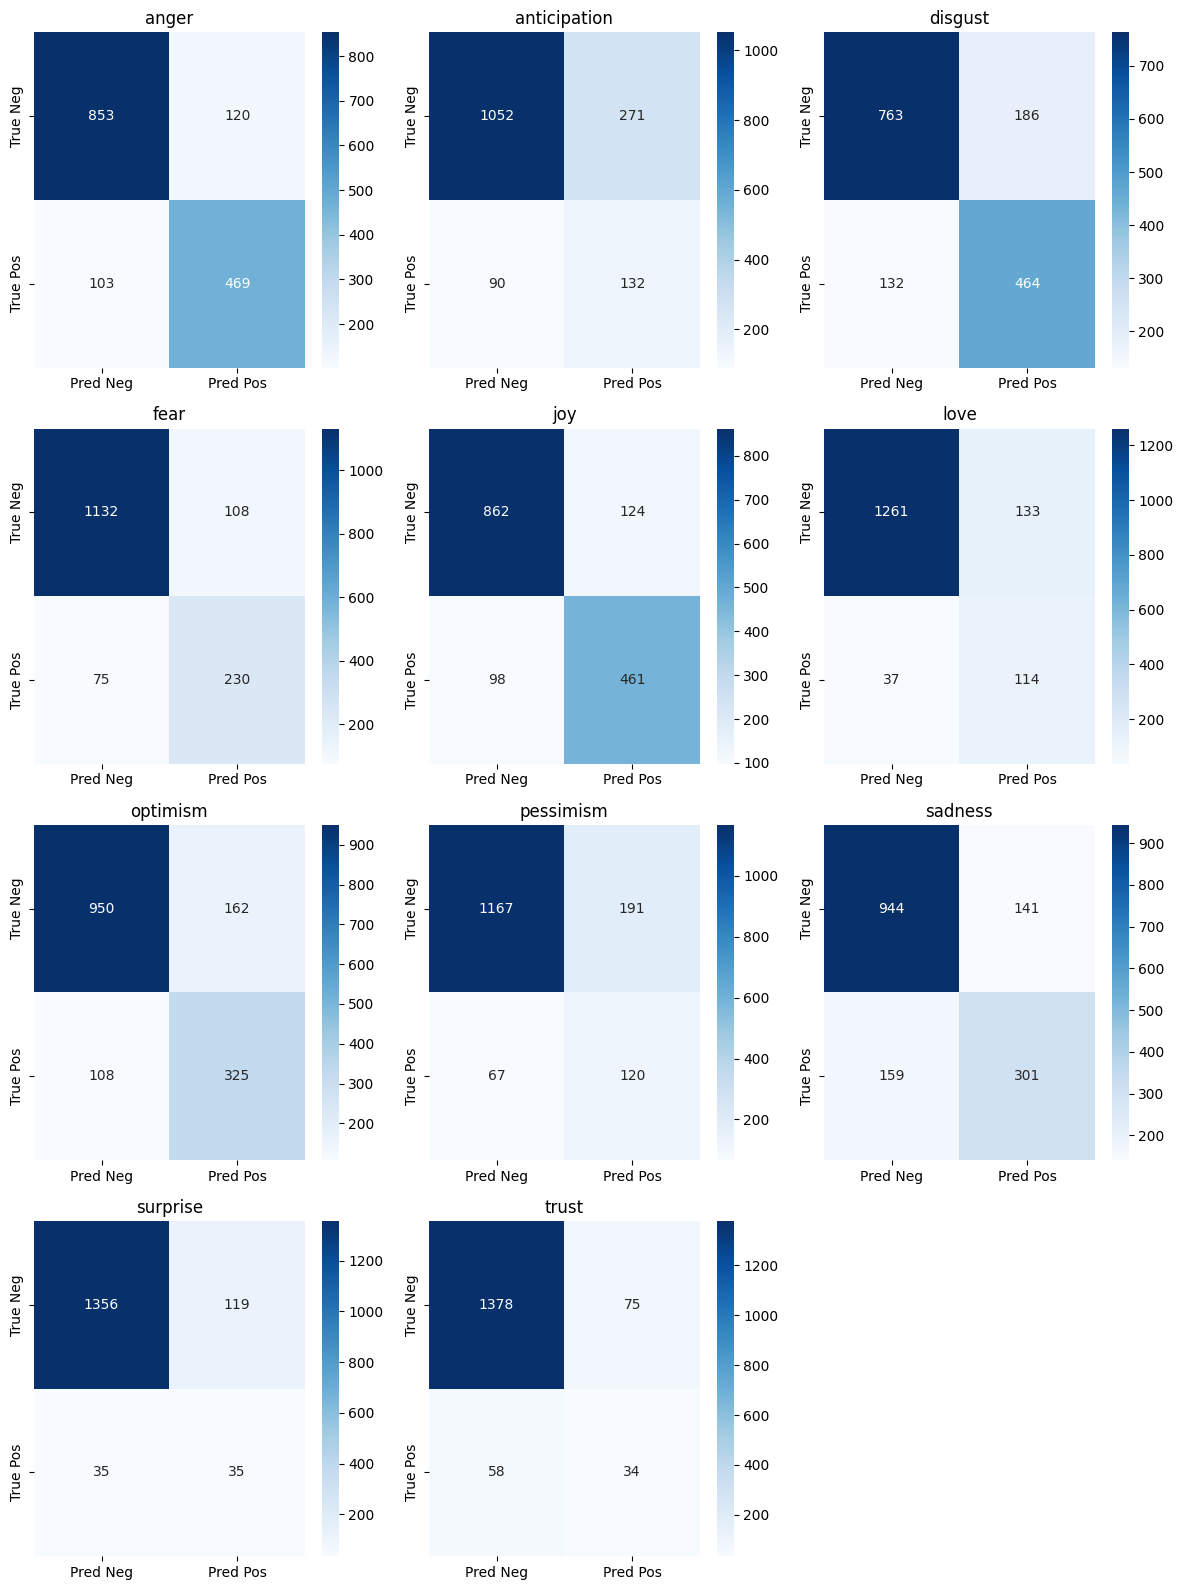

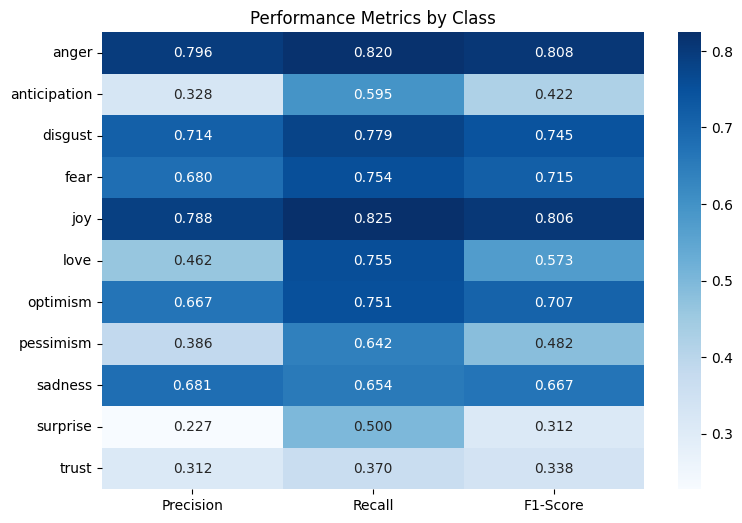

<Figure size 1200x533.333 with 0 Axes>

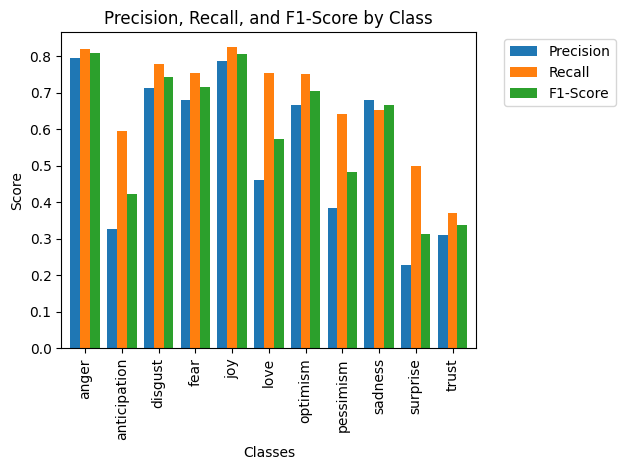

{'macro_avg': {'precision': 0.5491907712264668,
  'recall': 0.6766365440115313,
  'f1': 0.5978160125996627},
 'per_class': {'Precision': {'anger': 0.7962648556876061,
   'anticipation': 0.32754342431761785,
   'disgust': 0.7138461538461538,
   'fear': 0.6804733727810651,
   'joy': 0.788034188034188,
   'love': 0.46153846153846156,
   'optimism': 0.6673511293634496,
   'pessimism': 0.3858520900321543,
   'sadness': 0.6809954751131222,
   'surprise': 0.22727272727272727,
   'trust': 0.3119266055045872},
  'Recall': {'anger': 0.8199300699300699,
   'anticipation': 0.5945945945945946,
   'disgust': 0.7785234899328859,
   'fear': 0.7540983606557377,
   'joy': 0.8246869409660107,
   'love': 0.7549668874172185,
   'optimism': 0.7505773672055427,
   'pessimism': 0.6417112299465241,
   'sadness': 0.6543478260869565,
   'surprise': 0.5,
   'trust': 0.3695652173913043},
  'F1-Score': {'anger': 0.8079242032730405,
   'anticipation': 0.4224,
   'disgust': 0.7447833065810594,
   'fear': 0.7153965785

In [94]:
# Plot evaluation metrics for test set
multilabel_evaluation(y_true=val_labels, y_pred=val_dataset_preds, class_names=label_names)

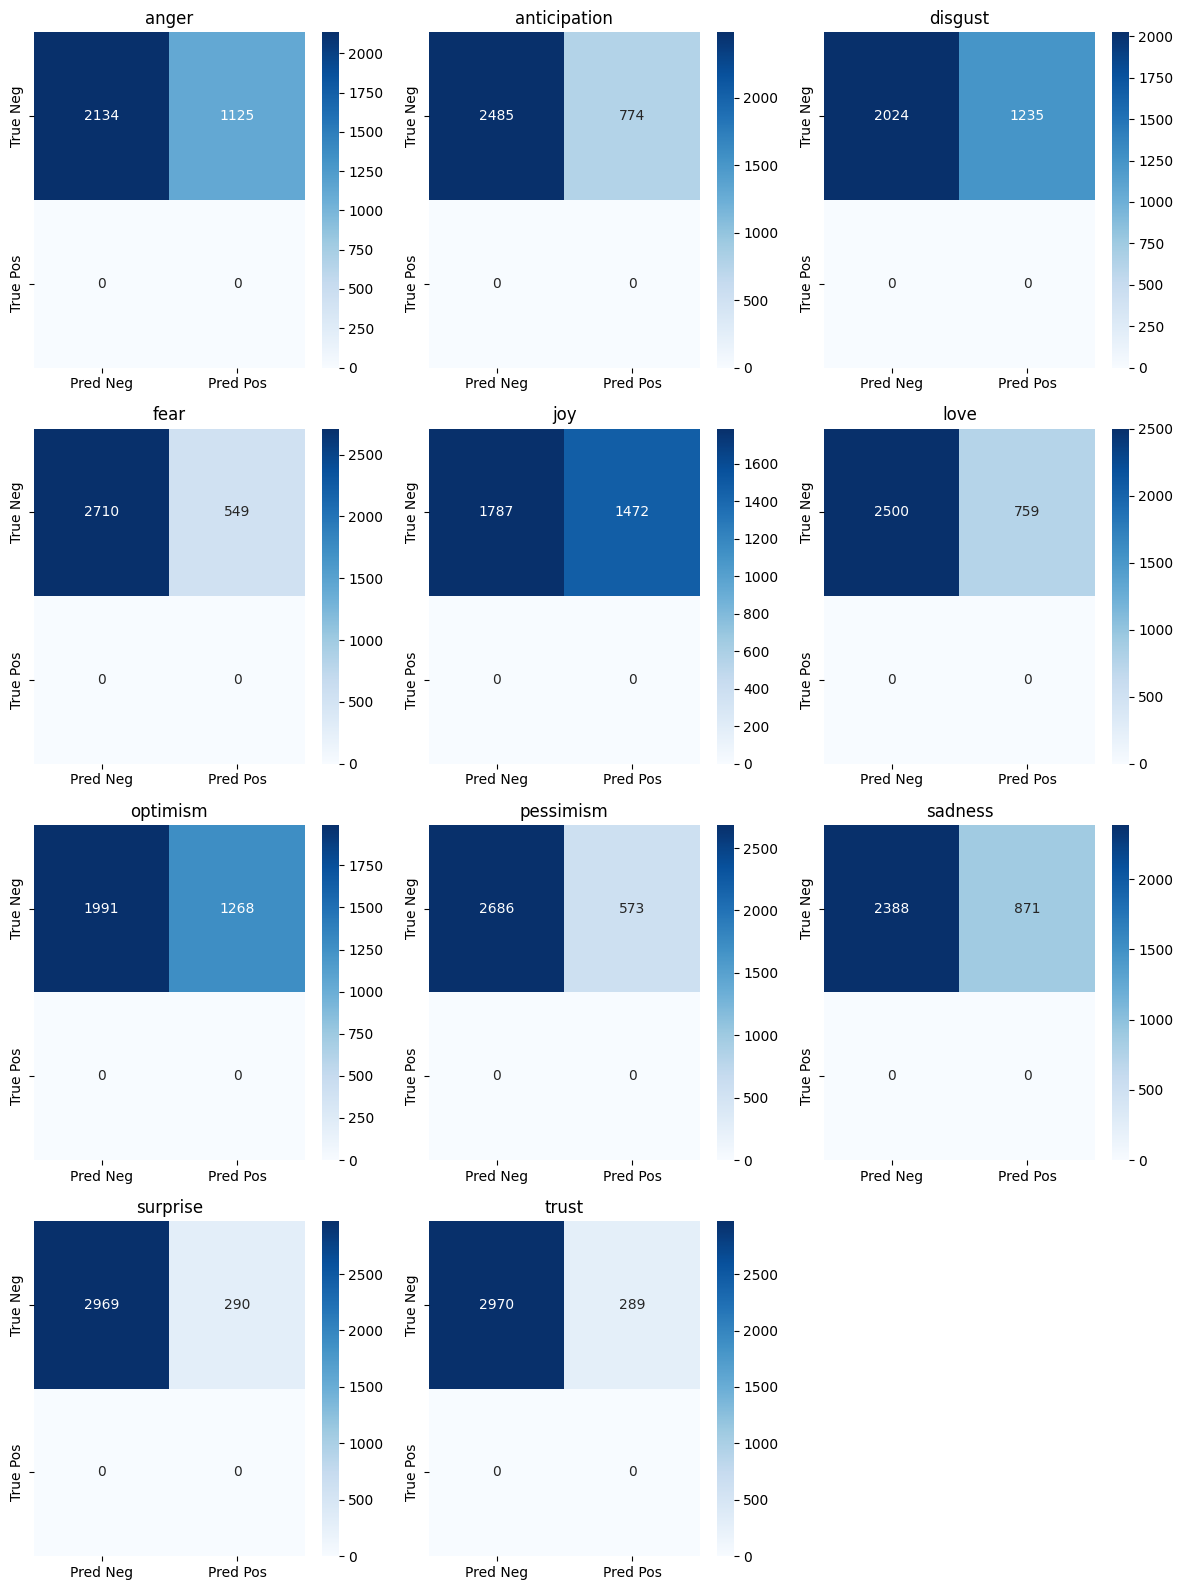

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


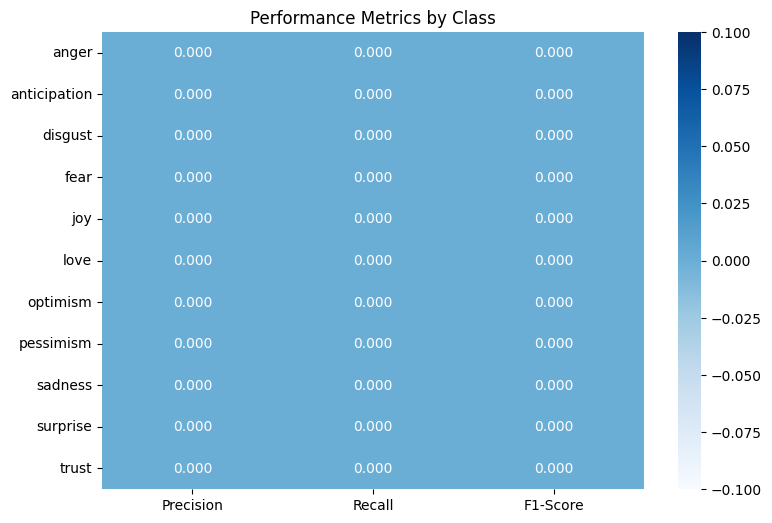

<Figure size 1200x533.333 with 0 Axes>

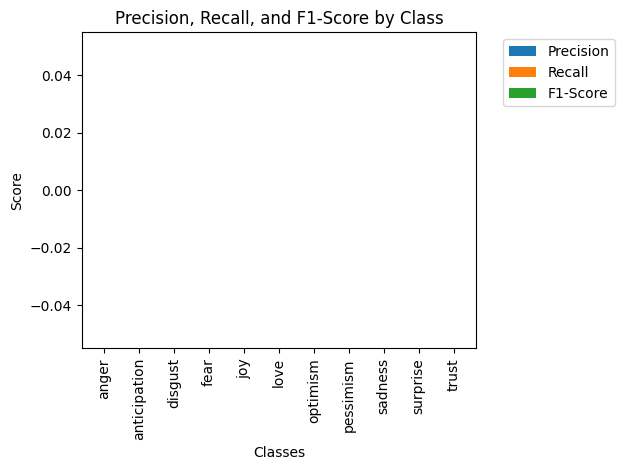

{'macro_avg': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0},
 'per_class': {'Precision': {'anger': 0.0,
   'anticipation': 0.0,
   'disgust': 0.0,
   'fear': 0.0,
   'joy': 0.0,
   'love': 0.0,
   'optimism': 0.0,
   'pessimism': 0.0,
   'sadness': 0.0,
   'surprise': 0.0,
   'trust': 0.0},
  'Recall': {'anger': 0.0,
   'anticipation': 0.0,
   'disgust': 0.0,
   'fear': 0.0,
   'joy': 0.0,
   'love': 0.0,
   'optimism': 0.0,
   'pessimism': 0.0,
   'sadness': 0.0,
   'surprise': 0.0,
   'trust': 0.0},
  'F1-Score': {'anger': 0.0,
   'anticipation': 0.0,
   'disgust': 0.0,
   'fear': 0.0,
   'joy': 0.0,
   'love': 0.0,
   'optimism': 0.0,
   'pessimism': 0.0,
   'sadness': 0.0,
   'surprise': 0.0,
   'trust': 0.0}}}

In [95]:
# Plot evaluation metrics for test set
multilabel_evaluation(y_true=test_labels, y_pred=test_preds, class_names=label_names)

In [96]:
# Best checkpoint identification for inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 800.


In [97]:
# Convert predictions and IDs to a DataFrame
test_ids = df_test["ID"].values  # Assuming you have df_test loaded with the test dataset including the ID column

# Convert predictions to a DataFrame
preds_df = pd.DataFrame(test_preds, columns=label_names)
preds_df.insert(0, "ID", test_ids)  # Insert IDs as the first column

In [99]:
# Save the DataFrame as a CSV file
preds_df.to_csv("Meta_LLama_3.2_1b_1.csv", index=False)
print("File saved as Meta_LLama_3.2_1b_1.csv")

File saved as Meta_LLama_3.2_1b_1.csv
